In [1]:
#Import packages
%matplotlib inline
import numpy as np
np.seterr(all='ignore')
import sympy
sympy.init_printing()
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg
import numba as nb

In [2]:
#Setting parameters
c=3*10**11                                                #(mm/s)
l=1                                                       #(mm)
timeunit=10**(-9)                                         #(10^(-9)s/ns)
ls=c*timeunit                                             #(mm/ns)
HalfLifeTime=98.3*10**(-9)                                #(s)
Gamma=np.log(2)*timeunit/HalfLifeTime                     #(1/ns)
xi=7.96*3                                                 #nuclear resonance thickness
ZeemanD=50                                                #unit of Gamma
eta=xi*Gamma/(2*l)                                        #(1/(ns*mm))
delta_1=ZeemanD*0.15532/(0.15532 + 0.090604)*Gamma
delta_2=ZeemanD*0.090604/(0.15532 + 0.090604)*Gamma
C_31=C_42=(2/3)**0.5                                      #CG coefficients
midp=50                                                   #(ns)
widp=5                                                    #(ns)
tDomain=100                                               #(total time:ns)
k=0                                                       #scale factor
M=3                                                       #number of targets
rate=500
velo=4.834*10**(-9)                                       #(mm/ns)
rmidt=60                                                  #(ns)

In [8]:
#Discretize time and space
dz=0.04*l
n_P=int(l/dz+1)
dt=0.00002*widp
n_T=int(tDomain/dt+1) 

z=np.linspace(0, l, n_P)
t=np.linspace(0, tDomain, n_T)
    
#Create 2-D arrays for rho_31, rho_42 and OmegaP (rows: time; columns: space)
rho_31=np.zeros((n_T, n_P), dtype=complex)
rho_42=np.zeros((n_T, n_P), dtype=complex)
OmegaP=np.zeros((n_T, n_P), dtype=complex)

#Initial and boundary conditions
rho_31[0, :]=0
rho_42[0, :]=0
OmegaP[0, :]=0
OmegaP[:, 0]=np.exp(-((t-midp)/widp)**2)

#Define the detuning in each discrete space
n, j=sympy.symbols("n, j")
a_n=sympy.Sum(sympy.exp(-((k*widp*(j-(M-1)/2)*(delta_1 + delta_2))/2)**2),(j, 0, n-1))\
        /sympy.Sum(sympy.exp(-((k*widp*(j-(M-1)/2)*(delta_1 + delta_2))/2)**2),(j, 0, M-1))*l

expr_func=sympy.lambdify(n, a_n.doit(), 'numpy')
nvalues=np.arange(1,M)
Cutpoint=expr_func(nvalues)

def heaviside(Z):
    return 1.0*(Z > 0)
Bstep=np.zeros((M-1, n_P))

for i in range(0,M-1):
    Bstep[i,:]=heaviside(z-Cutpoint[i])

delta_g=(np.sum(Bstep, axis=0)-(M-1)/2)*delta_1
delta_e=(np.sum(Bstep, axis=0)-(M-1)/2)*delta_2
    
#Create Doppler velocity 
deltaV=(14.4*1000)/(6.582*10**(-16))*timeunit*(velo/ls)*(np.tanh((t-rmidt)/(0.05*rate))+1)*0.5
deltaV_expand=deltaV[:,np.newaxis]
    
@nb.jit(nopython=True)
def PDE_jit(rho_31, rho_42, OmegaP):
        idx=0
        #Solving PDE by finite difference method
        for s in range(1, n_T):
            #Define 1-D spatial forward difference in each row 
            deltaOmegaP_z=(OmegaP[idx, 1:]-OmegaP[idx, 0:-1])/dz
    
            rho_31c=rho_31[idx, 1:]
            rho_42c=rho_42[idx, 1:]
            OmegaPc=OmegaP[idx, 1:]
    
            rho_31[idx+1, 1:]=rho_31c+dt*(-Gamma/2*rho_31c-np.complex(0,1)/2*(2*(delta_g[1:]+delta_e[1:]+deltaV_expand[idx])*rho_31c-C_31/2*OmegaPc))
            rho_42[idx+1, 1:]=rho_42c+dt*(-Gamma/2*rho_42c+np.complex(0,1)/2*(2*(delta_g[1:]+delta_e[1:]+deltaV_expand[idx])*rho_42c+C_42/2*OmegaPc))
            OmegaP[idx+1, 1:]=OmegaPc+dt*(np.complex(0,1)*ls*(8*eta/(0.5*(C_31**2+C_42**2)))*(C_31*rho_31c+C_42*rho_42c)-ls*deltaOmegaP_z)
            idx=idx+1
        return rho_31, rho_42, OmegaP

In [11]:
%time 
rho_31, rho_42, OmegaP=PDE_jit(rho_31, rho_42, OmegaP)

Wall time: 1.6 s


In [4]:
%timeit PDE_jit(rho_31, rho_42, OmegaP)

1.51 s ± 6.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%time 
rho_31, rho_42, OmegaP=PDE_jit(rho_31, rho_42, OmegaP)

Wall time: 1.53 s


In [14]:
%time 
rho_31, rho_42, OmegaP=PDE_jit(rho_31, rho_42, OmegaP)

Wall time: 1min 14s


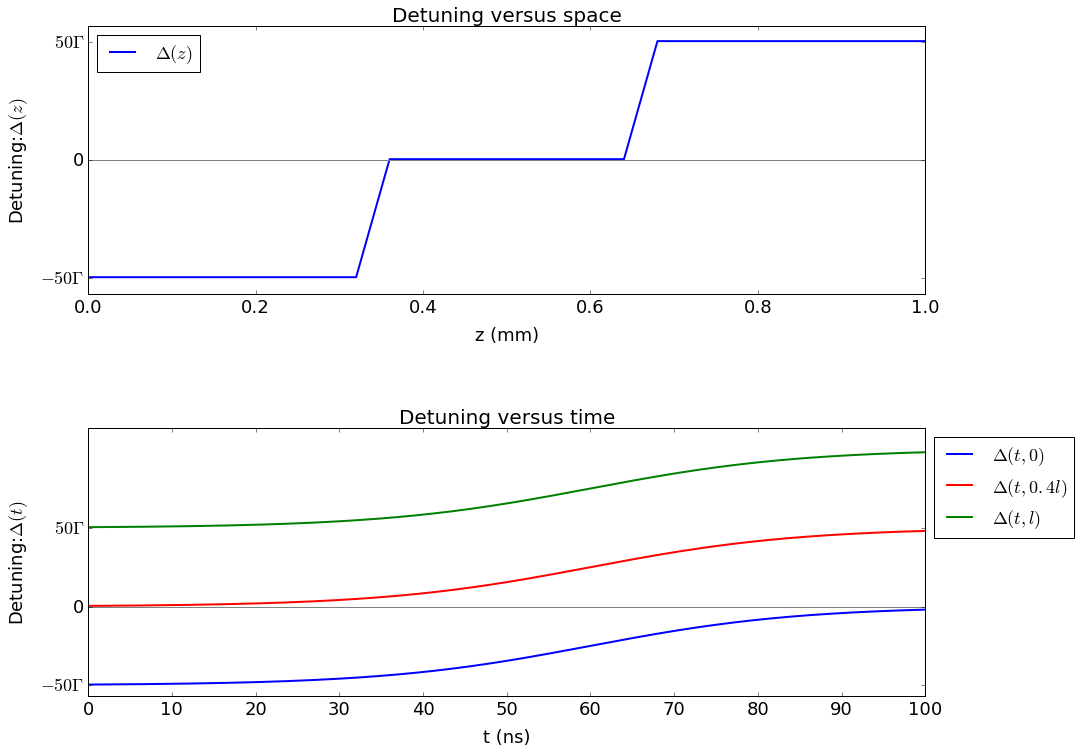

In [8]:
TotalDetuning_i=delta_g+delta_e+deltaV[:,np.newaxis][0]
#Plot the detuning in space(z)
fig, axes = plt.subplots(2, 1, figsize=(15, 12))
axes[0].plot(z, TotalDetuning_i, color='b', label=r"$\Delta(z)$", lw=2)
axes[0].set_xlabel("z (mm)", fontsize=18, labelpad=10)
axes[0].set_ylabel(r"Detuning:$\Delta(z)$", fontsize=18, labelpad=10)
axes[0].set_title("Detuning versus space", fontsize=20)
axes[0].set_xlim(0,l)
axes[0].tick_params(axis='both', labelsize=18)
axes[0].xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2*l))
axes[0].set_yticks([-ZeemanD*Gamma, 0, ZeemanD*Gamma])
axes[0].set_yticklabels([r"$-50\Gamma$", 0, r"$50\Gamma$"])
axes[0].legend(fontsize=18, loc=2)
axes[0].axhline(0, linestyle='-', color='grey')

axes[1].plot(t, delta_g[0]+delta_e[0]+deltaV[:,np.newaxis][:,0], color='b', label=r"$\Delta(t,0)$", lw=2)
axes[1].plot(t, delta_g[int(n_P/2)]+delta_e[int(n_P/2)]+deltaV[:,np.newaxis][:,0], color='r', label=r"$\Delta(t,0.4l)$", lw=2)
axes[1].plot(t, delta_g[-1]+delta_e[-1]+deltaV[:,np.newaxis][:,0], color='g', label=r"$\Delta(t,l)$", lw=2)
axes[1].set_xlabel("t (ns)", fontsize=18, labelpad=10)
axes[1].set_ylabel(r"Detuning:$\Delta(t)$", fontsize=18, labelpad=10)
axes[1].set_title("Detuning versus time", fontsize=20)
axes[1].set_xlim(0,100)
axes[1].tick_params(axis='both', labelsize=18)
axes[1].xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
axes[1].set_yticks([-ZeemanD*Gamma, 0, ZeemanD*Gamma])
axes[1].set_yticklabels([r"$-50\Gamma$", 0, r"$50\Gamma$"])
axes[1].legend(fontsize=18, loc=2, bbox_to_anchor=(1, 1))
axes[1].axhline(0, linestyle='-', color='grey')
plt.subplots_adjust(hspace=0.5)

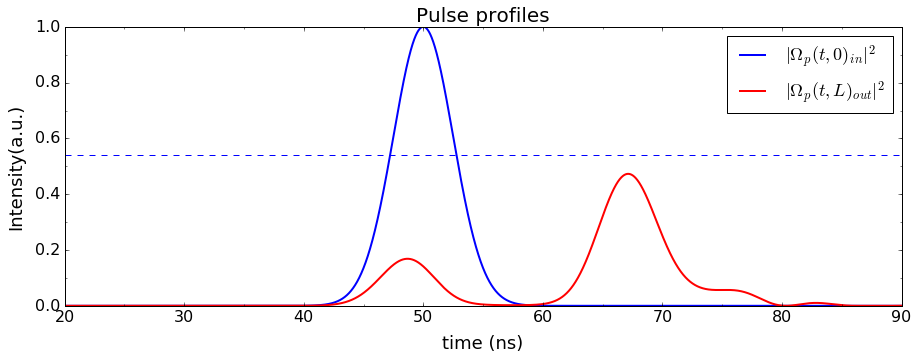

In [10]:
#Plot the input and output pulse
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(t, np.abs(OmegaP[:,0])**2, color='b', label=r"$|\Omega_p(t,0)_{in}|^{2}$", lw=2)
ax.plot(t, np.abs(OmegaP[:,-1])**2, color='r', label=r"$|\Omega_p(t,L)_{out}|^{2}$", lw=2)
ax.set_xlabel("time (ns)", fontsize=18, labelpad=10)
ax.set_ylabel("Intensity(a.u.)", fontsize=18, labelpad=10)
ax.set_title("Pulse profiles", fontsize=20)
ax.set_xlim(20,90)
ax.tick_params(labelsize=16)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.legend(fontsize=18)
ax.axhline(0.54, linestyle='--')

In [10]:
#Calculate the first echo efficiency
efficiency=(np.sum(np.abs(OmegaP[int(60/dt+1):int(80/dt+1),-1])**2*dt))/(np.sum(np.abs(OmegaP[int(40/dt+1):int(60/dt+1),0])**2*dt))
print(sympy.Float(efficiency, 4))

0.5157


In [12]:
nb.__version__

'0.22.1'